# Step 3: Factor Combination: AdaBoost

In this part, we combine the factors to synthesis mega alpha using AdaBoost in the quantopian platform since we want the US stock analysis(cannot download locally freely). Fortunately, there are several machine learning libraries such as scikit learning available in Quantopian so that we can pull and analysis data online. Note the code is only valid in Quantopian $\rightarrow$ Research $\rightarrow$ Notebooks.

In [296]:
from quantopian.research import run_pipeline
from quantopian import research
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US, QTradableStocksUS
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline import data
from quantopian.pipeline import filters
from quantopian.pipeline import factors
from quantopian.pipeline import classifiers


import talib
import pandas as pd
idx = pd.IndexSlice
import seaborn as sns; sns.set()

import numpy as np
import scipy as sp
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# from Ipython import display
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [4]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
    def Sector_Code():
        return data.Fundamentals.morningstar_sector_code.latest   
    
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,
#         "sector_code": Sector_Code
    }        
    
    return all_factors

In [5]:


def make_factors2():
    class Value(CustomFactor):
    
        inputs = [data.Fundamentals.book_value_yield,
              data.Fundamentals.sales_yield,
              data.Fundamentals.fcf_yield] 
    
        window_length = 1
    
        def compute(self, today, assets, out, book_value, sales, fcf):
            value_table = pd.DataFrame(index=assets)
            value_table["book_value"] = book_value[-1]
            value_table["sales"] = sales[-1]
            value_table["fcf"] = fcf[-1]
            out[:] = value_table.rank().mean(axis=1)
    
    
    class Momentum(CustomFactor):
    
        inputs = [USEquityPricing.close]
        window_length = 252
    
        def compute(self, today, assets, out, close):
            out[:] = close[-20] / close[0]

            
    class Quality(CustomFactor):
    
        inputs = [data.Fundamentals.gross_profit, data.Fundamentals.total_assets]
        window_length = 1
    
        def compute(self, today, assets, out, gross_profit, total_assets):       
            out[:] = gross_profit[-1] / total_assets[-1]
        
        
    class Volatility(CustomFactor):
    
        inputs = [USEquityPricing.close]
        window_length = 252
    
        def compute(self, today, assets, out, close):  
            close = pd.DataFrame(data=close, columns=assets) 
            # Since we are going to rank largest is best we need to invert the sdev.
            out[:] = 1 / np.log(close).diff().std()
        
    class CashLiquidity(CustomFactor):
        inputs = [data.Fundamentals.cash, data.Fundamentals.total_assets]
        window_length = 1
    
        def compute(self, today, assets, out, cash, total_assets):
            out[:] = cash[-1]/total_assets[-1]
        
    class ChangeInOutstanding(CustomFactor):
        inputs = [data.Fundamentals.shares_outstanding]
        window_length=22
        def compute(self, today, assets, out, outstanding):
            out[:] = outstanding[-1] - outstanding[-20]
            
    def Sector_Code():
        return data.Fundamentals.morningstar_sector_code.latest
    
    def Net_Income_Margin():
        return or_.net_margin.latest 
    def Market_Cap():
        return data.Fundamentals.market_cap.latest
    def Pb_Ratio():
        return data.Fundamentals.pb_ratio.latest
    def Ps_Ratio():
        return data.Fundamentals.ps_ratio.latest
    def Priceto_Ebitda():
        return data.Fundamentals.priceto_ebitda.latest
    def Roe():
        return data.Fundamentals.roe.latest
    def Roa():
        return data.Fundamentals.roa.latest
    def Sales_Yield():
        return data.Fundamentals.sales_yield.latest
    def Total_Yield():
        return data.Fundamentals.total_yield.latest
    
    all_factors = {
#         "daily_return": factors.Returns(window_length=2),
        "market_cap": Market_Cap,
        
        "pb_ratio": Pb_Ratio,
        'total_yield': Total_Yield,
        'priceto_ebitda': Priceto_Ebitda,        
        "ps_ratio": Ps_Ratio,
#         "sector_code": Sector_Code,
#         "fcf_yield": data.Fundamentals.fcf_yield.latest,
        'gross_profit_assets_ratio': Quality,
#         'gross_margin': data.Fundamentals.gross_margin.latest,        
        "roe": Roe,
        "roa": Roa,
        "sales_yield": Sales_Yield,
        "momentum": Momentum,
#         "accrued_investment_income": data.Fundamentals.accrued_investment_income.latest,
#         "asset_turnover": data.Fundamentals.assets_turnover.latest,
#         "cap_ex_sales_ratio": data.Fundamentals.cap_ex_sales_ratio.latest,
#         "financial_health_grade": data.Fundamentals.financial_health_grade.latest,
#         "cash_liquidity": CashLiquidity,
#         "change_in_outstanding": ChangeInOutstanding,
        "net_income_margin":Net_Income_Margin,
    }  
    
    return all_factors

In [381]:
sector = 207
# universe = Q1500US()
universe = QTradableStocksUS()
# factors = make_factors()
factors = make_factors2()
n_fwd_days = 22 # number of days to compute returns over

In [8]:
def make_history_pipeline(factors, universe, n_fwd_days=22):
    # Call .rank() on all factors and mask out the universe
    factor_ranks = {name: f().rank(mask=universe) for name, f in factors.iteritems()}
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    factor_ranks["sector_code"] = data.Fundamentals.morningstar_sector_code.latest
    pipe = Pipeline(screen=universe & factor_ranks["sector_code"].eq(sector), columns=factor_ranks)
    
    return pipe

In [9]:
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

In [10]:
start_timer = time()
start = pd.Timestamp("2016-03-06")
end = pd.Timestamp("2018-04-06")
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()

In [11]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 50.17 secs


In [12]:
results.head()

Returns  \
date                      security                       
2016-03-07 00:00:00+00:00 Equity(161 [AEP])  -0.005891   
                          Equity(166 [AES])   0.108395   
                          Equity(612 [ATO])   0.008255   
                          Equity(913 [BKH])   0.132771   
                          Equity(1521 [CPK]) -0.116792   

                                              gross_profit_assets_ratio  \
date                      security                                        
2016-03-07 00:00:00+00:00 Equity(161 [AEP])                       482.0   
                          Equity(166 [AES])                       177.0   
                          Equity(612 [ATO])                       625.0   
                          Equity(913 [BKH])                       615.0   
                          Equity(1521 [CPK])                      781.0   

                                              market_cap  momentum  \
date                      security                                   
2016-03-07 00:00:00+00:00 Equity(161 [AEP])       1920.0    1851.0   
                          Equity(166 [AES])       1530.0     940.0   
                          Equity(612 [ATO])       1536.0    2006.0   
                          Equity(913 [BKH])       1076.0    1688.0   
                          Equity(1521 [CPK])       333.0    2018.0   

                                              net_income_margin  pb_ratio  \
date                      security                                          
2016-03-07 00:00:00+00:00 Equity(161 [AEP])              1524.0     640.0   
                          Equity(166 [AES])               404.0     914.0   
                          Equity(612 [ATO])              1442.0     892.0   
                          Equity(913 [BKH])               368.0     774.0   
                          Equity(1521 [CPK])             1216.0    1049.0   

                                              priceto_ebitda  ps_ratio  \
date                      security                                       
2016-03-07 00:00:00+00:00 Equity(161 [AEP])            334.0     970.0   
                          Equity(166 [AES])             47.0     196.0   
                          Equity(612 [ATO])            682.0     988.0   
                          Equity(913 [BKH])           1385.0    1005.0   
                          Equity(1521 [CPK])           678.0    1018.0   

                                                 roa     roe  sales_yield  \
date                      security                                          
2016-03-07 00:00:00+00:00 Equity(161 [AEP])   1033.0  1102.0       1104.0   
                          Equity(166 [AES])    442.0   341.0       1871.0   
                          Equity(612 [ATO])   1239.0  1244.0       1086.0   
                          Equity(913 [BKH])    415.0   416.0       1070.0   
                          Equity(1521 [CPK])  1079.0  1042.0       1057.0   

                                              sector_code  total_yield  
date                      security                                      
2016-03-07 00:00:00+00:00 Equity(161 [AEP])           207        943.0  
                          Equity(166 [AES])           207       1725.0  
                          Equity(612 [ATO])           207        693.0  
                          Equity(913 [BKH])           207        826.0  
                          Equity(1521 [CPK])          207        603.0

In [169]:
def calculate_valid_universe(df):
        idx = pd.IndexSlice
        valid_universe = set(df.index.get_level_values(level=1).unique())

        for date,group in df.groupby(level=0):
            size = group.shape[0]
#             print(group.loc[idx[:,valid_universe],:])
#             print(group.loc[idx[:,valid_universe]])
#             print(group.loc[valid_universe])
            new_set = set(group.loc[idx[:,valid_universe],:].index.get_level_values(1).values)
            if(new_set<valid_universe):
                valid_universe = new_set
            
        # self.valid_universe = valid_universe 
        valid_universe = np.sort(list(valid_universe))
        return valid_universe     


In [123]:
def calculate_valid_dataframe(results,valid_universe):
    n_valid_universe = len(valid_universe)
    n_days = len(results.index.get_level_values(level=0).unique())
    results_valid = results.loc[idx[:,valid_universe],:].copy()
    returns_valid = results_valid.pop("Returns")
    results_valid = results_valid.ix[:-22*n_valid_universe]
    returns_valid = returns_valid.shift(n_valid_universe*22).dropna(axis=0)
    results_valid["fwd_returns"] = returns_valid.values
    # Preprocessing for missing values
#     imputer = preprocessing.Imputer(strategy="mean",axis=1)
#     scaler = preprocessing.MinMaxScaler()
#     results_valid = imputer.fit_transform(results_valid)
#     results_valid = scaler.fit_transform(results_valid)
    results_valid = results_valid.fillna(results_valid.mean())
    return results_valid

In [289]:
def results_to_tensors(results_valid):
    n_valid_universe = len(valid_universe)
    n_days = len(results_valid.index.get_level_values(level=0).unique())
    X_tensor = results_valid.drop(["sector_code","fwd_returns"],axis=1).values.reshape(n_days,n_valid_universe,-1)
    Y_matrix = results_valid["fwd_returns"].reshape(n_days,n_valid_universe)
    return X_tensor, Y_matrix

In [235]:
def train_test_split(X_tensor,Y_matrix,train_perc=0.8):
    # Train-test split
    n_days, n_stocks, n_factors = X_tensor.shape
    train_size = np.int16(np.round(train_size_perc * n_days))
    print("train size: {} days".format(train_size))
    X_tensor_train, Y_matrix_train = X_tensor[:train_size, ...], Y_matrix[:train_size]
    # X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]
    X_tensor_test, Y_matrix_test = X_tensor[train_size:, ...], Y[train_size:]
    return X_tensor_train, Y_matrix_train, X_tensor_test, Y_matrix_test

In [236]:
def mask_data(X_tensor,Y_matrix,upper_percentile=70,lower_percentile=30):
    # X: (n_days, n_valid_universe, n_features)
    # Y: (n_days, n_valid_universe)
    # Look for biggest up and down movers
    n_times,n_stocks, n_factors = np.shape(X_tensor)
    upper = np.nanpercentile(Y_matrix, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y_matrix, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y_matrix > upper)
    lower_mask = (Y_matrix <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten() # mask: (n_times * n_stocks)
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_times * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X_tensor.reshape((n_times * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

In [324]:
def preprocessing_transformation(X_train,X_test):
    imputer = preprocessing.Imputer()
    scaler = preprocessing.MinMaxScaler()
    X_train_trans = imputer.fit_transform(X_train)
    X_train_trans = scaler.fit_transform(X_train)
    X_test_trans = imputer.fit_transform(X_test)
    X_test_trans = scaler.fit_transform(X_test)
    return X_train_trans, X_test_trans

In [310]:
def pca_transformation(X_train,X_test,explained_ratio_thresh=0.02):
    pca = PCA()
    pca.fit(X_train)
    n_components = (pca.explained_variance_ratio_>explained_ratio_thresh).sum()
    X_train_trans = pca.transform(X_train)[:,:n_components]
    X_test_trans = pca.transform(X_test)[:,:n_components]
    return X_train_trans,X_test_trans

In [312]:
def adaboost_classifier(X_train_trans, Y_binary_train):
    clf = ensemble.AdaBoostClassifier(n_estimators=400) # n_estimators controls how many weak classifiers are fitted
    clf.fit(X_train, Y_binary_train)
    return clf

In [398]:
def decision_separate_plot(scores, Y_binary):
    class_names="AB"
    plot_colors="br"
    plot_range = (scores.min(), scores.max())
    for i, n, c in zip([-1,1], class_names, plot_colors):
        plt.hist(scores[Y_binary == i],
             bins=50,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
    plt.legend(loc='upper right')
    plt.ylabel('Samples')
    plt.xlabel('Score')
    plt.title('Decision Scores')
#         plt.ylim((0,500))

In [394]:
def prec_quantile_plot(scores,obs):
    categ = pd.qcut(scores,5,labels=[20,40,60,80,100])
#     categ = pd.qcut(scores,5,labels="abcde")
    categ = categ.get_values()
    valid_df = pd.DataFrame()
    valid_df["score"]=scores
    valid_df["obs"] = obs
    valid_df["category"] = categ
    binary = np.zeros(len(scores))
    binary[scores>0]=1
    binary[scores<=0]=-1
    valid_df["score_binary"] = binary
    valid_df["is_correct"] = valid_df["obs"] * valid_df["score_binary"]
    valid_df["is_correct"][valid_df["is_correct"]==-1]=0
    valid_df
#     print(valid_df)
    prec_dict = dict()
    for cat,group in valid_df.groupby(by="category"):
        prec_dict[cat]=group["is_correct"].sum()/len(group)
        
    prec_df = pd.DataFrame()
    prec_df["quantile"] = prec_dict.keys()
    prec_df["precision"] = prec_dict.values()
    plt.ylim(0,1)
    sns.barplot(x="quantile",y="precision",data=prec_df.copy())

    return

In [318]:
valid_universe = calculate_valid_universe(results)
results_valid = calculate_valid_dataframe(results,valid_universe)
X_tensor, Y_matrix = results_to_tensors(results_valid)
X_tensor_train, Y_matrix_train, X_tensor_test, Y_matrix_test = \
    train_test_split(X_tensor,Y_matrix,train_perc=0.8)
X_train,Y_binary_train = \
    mask_data(X_tensor_train,Y_matrix_train,upper_percentile=70,lower_percentile=30)
X_test,Y_binary_test = mask_data(X_tensor_test,Y_matrix_test,upper_percentile=50,lower_percentile=50)

train size: 403 days


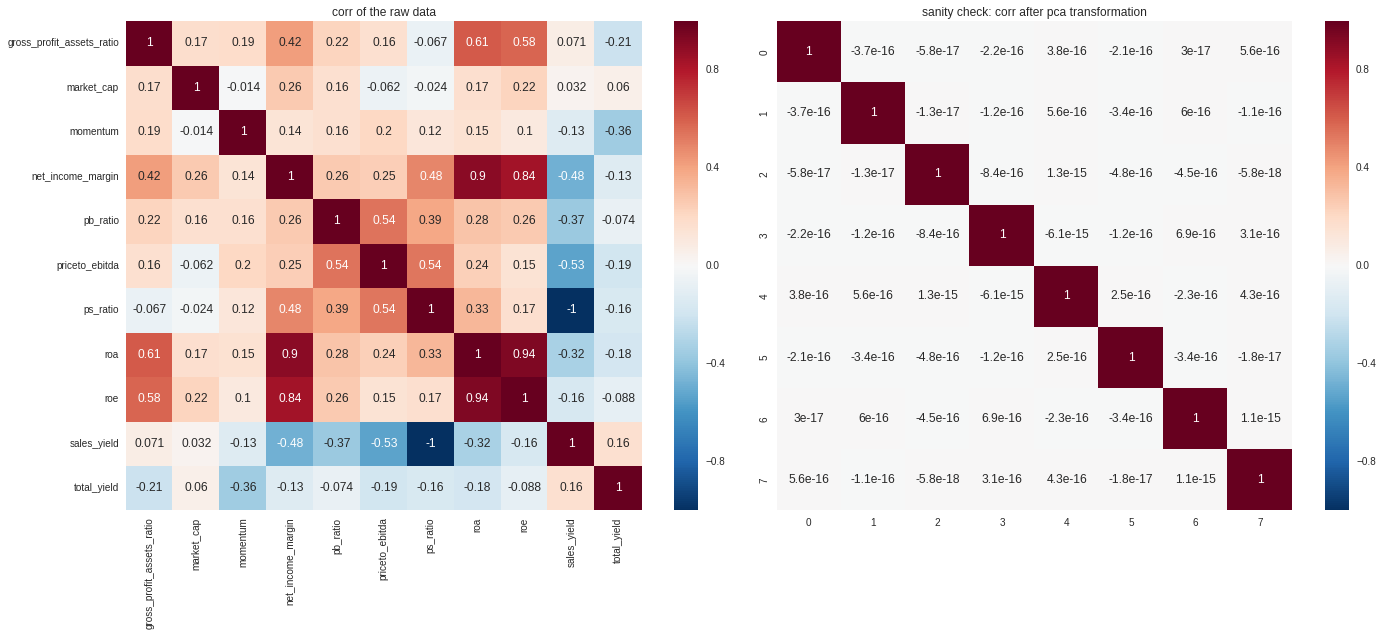

In [390]:
plt.figure(figsize=(20,9))
# print("corr of the raw data")
plt.subplot(1,2,1)
plt.title("corr of the raw data")

X_columns = results_valid.drop(["fwd_returns","sector_code"],axis=1).columns.values
sns.heatmap(pd.DataFrame(X_train,columns=X_columns).corr(),annot=True)

# print("sanity check: corr after pca transformation")
plt.subplot(1,2,2)
plt.title("sanity check: corr after pca transformation")
X_after_pca_df = pd.DataFrame(X_train_pca_trans)
sns.heatmap(X_after_pca_df.corr(),annot=True)
plt.tight_layout()

In [328]:
X_train_pre_trans, X_test_pre_trans = preprocessing_transformation(X_train,X_test)

In [329]:
X_train_pca_trans, X_test_pca_trans = pca_transformation(X_train_pre_trans,X_test_pre_trans)

In [331]:
clf = adaboost_classifier(X_train_pca_trans,Y_binary_train)

In [335]:
Y_pred_train = clf.predict(X_train_pca_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_binary_train, Y_pred_train) * 100))

Accuracy on train set = 70.03%


In [336]:
Y_pred_test = clf.predict(X_test_pca_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_binary_test, Y_pred_test) * 100))

Accuracy on train set = 49.87%


In [351]:
Y_train_scores = clf.decision_function(X_train_pca_trans)
Y_test_scores = clf.decision_function(X_test_pca_trans)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


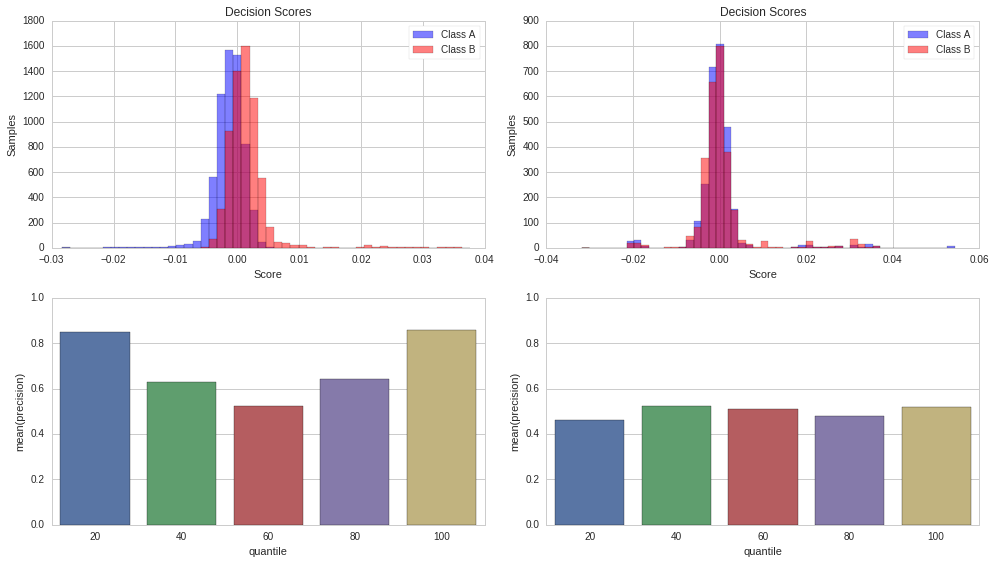

In [402]:
plt.subplot(2,2,1)
decision_separate_plot(Y_train_scores,Y_binary_train)
plt.subplot(2,2,2)
decision_separate_plot(Y_test_scores,Y_binary_test)
plt.subplot(2,2,3)
prec_quantile_plot(Y_train_scores,Y_binary_train)
plt.subplot(2,2,4)
prec_quantile_plot(Y_test_scores,Y_binary_test)
# axes = plt.axes()
plt.tight_layout()

In these pictures, I draw the score histogram and the mean precision vs. quantile plot. The left side is the train set, and the right side is the test set.